In [1]:
import warnings

warnings.filterwarnings("ignore")

import os
import sys

dir2 = os.path.abspath("")
dir1 = os.path.dirname(dir2)
if dir1 not in sys.path:
    sys.path.append(dir1)

os.chdir("..")

In [3]:
import numpy as np
from scipy.stats import wasserstein_distance, wasserstein_distance_nd

In [4]:
a = np.random.randn(3, 10)
b = np.random.randn(3, 10)

a_flat = a.flatten()
b_flat = b.flatten()

In [6]:
%%timeit
wasserstein_distance(a_flat, b_flat)

37.9 µs ± 1.28 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [7]:
%%timeit
wasserstein_distance_nd(a, b)

2.15 ms ± 50.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [3]:
import itertools
import math

import matplotlib.pyplot as plt
import numpy as np
import yaml
from src.datasets.datasets import AllModelsOutputDataset, CPDDatasets, OutputDataset
from src.ensembles.ensembles import (
    CusumEnsembleCPDModel,
    EnsembleCPDModel,
)
from src.metrics.evaluation_pipelines import (
    evaluate_cusum_ensemble_model,
    evaluate_distance_ensemble_model,
    evaluation_pipeline,
)
from src.metrics.metrics_utils import (
    collect_model_predictions_on_set,
    compute_stds,
)
from src.utils.fix_seeds import fix_seeds
from src.utils.visualize import visualize_predictions
from torch.utils.data import DataLoader

%load_ext autoreload
%autoreload
%matplotlib inline

In [3]:
def mimic_abannealing_lr(start_lr, final_lr, gamma, T_max, last_epoch=-1):
    lrs = [start_lr]
    for _ in range(last_epoch):
        base_lr = lrs[-1]
        b = T_max / ((base_lr / final_lr) * math.exp(1 / gamma) - 1.0)
        a = base_lr * b**gamma

        new_lr = a / (b + last_epoch) ** gamma
        lrs.append(new_lr)
    return lrs

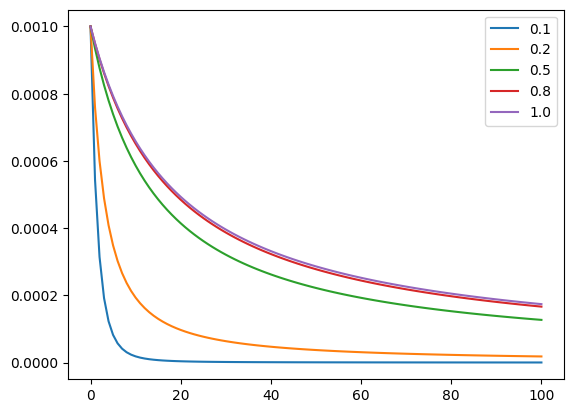

In [4]:
plt.figure()
for gamma in [0.1, 0.2, 0.5, 0.8, 1.0]:
    lrs_array = mimic_abannealing_lr(
        start_lr=1e-3, final_lr=1e-4, gamma=gamma, T_max=50000, last_epoch=100
    )
    plt.plot(lrs_array, label=gamma)
plt.legend()
plt.show()

# HAR

In [4]:
SEED = 42
fix_seeds(SEED)

model_type = "seq2seq"

experiments_name = "human_activity"

path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"

with open(path_to_config, "r") as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type

args_config["loss_type"] = "bce"
args_config["num_workers"] = 2
args_config["learning"]["gpus"] = 1

args_config["learning"]["epochs"] = 100

In [5]:
train_dataset, test_dataset = CPDDatasets(experiments_name).get_dataset_()
train_dataset[0][0].shape

(20, 28)

## Ensemble

In [6]:
path_to_models_folder = "saved_models/bce/human_activity/sgld_adam"

ens_har_sgld = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)
ens_har_sgld.load_models_list(path_to_models_folder)

In [7]:
test_dataset = ens_har_sgld.test_dataset
test_dataloader = DataLoader(
    test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=True
)

seq_batch, labels_batch = next(iter(test_dataloader))

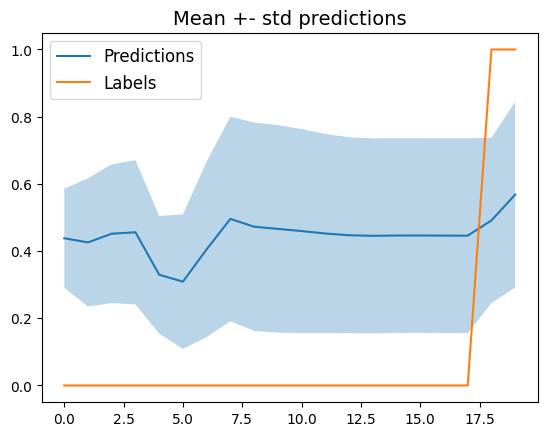

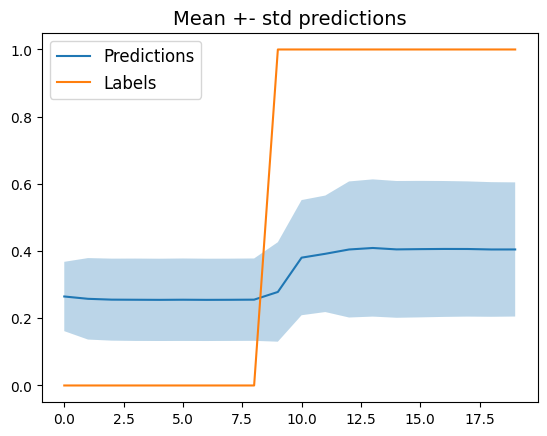

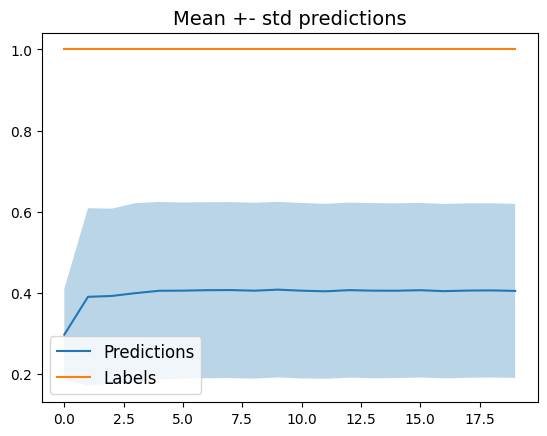

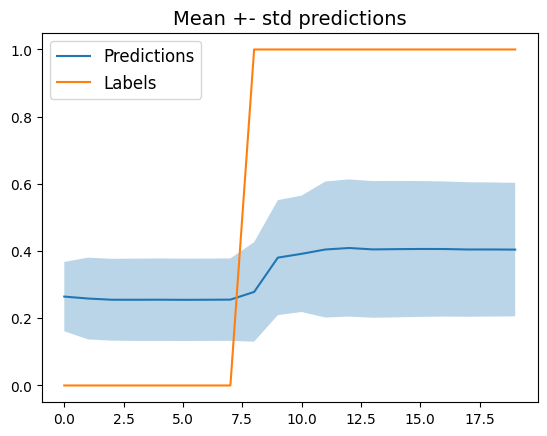

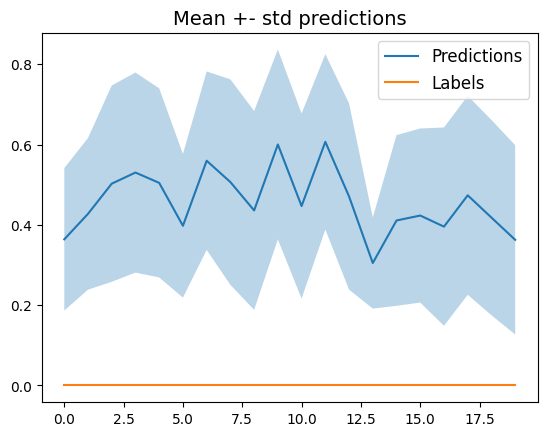

In [8]:
visualize_predictions(ens_har_sgld, "ensemble", seq_batch, labels_batch, n_pics=5)

In [16]:
# collecting outputs
test_out_bank, test_uncertainties_bank, test_labels_bank = (
    collect_model_predictions_on_set(
        ens_har_sgld, test_dataloader, model_type="ensemble", device="cpu"
    )
)

out_dataset = OutputDataset(test_out_bank, test_uncertainties_bank, test_labels_bank)
out_dataloader = DataLoader(out_dataset, batch_size=128, shuffle=False)

(preds, stds), labels = out_dataset[0]
preds.shape, stds.shape, labels.shape

Collectting model's outputs


(torch.Size([20]), torch.Size([20]), torch.Size([20]))

In [27]:
threshold_number = 50
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

metrics, (max_th_f1_margins_dict, max_f1_margins_dic), _, _ = evaluation_pipeline(
    ens_har_sgld,
    test_dataloader,
    threshold_list,
    device="cpu",
    model_type="ensemble",
    verbose=True,
    margin_list=[1, 2, 4],
)

Collectting model's outputs
TN: 2, FP: 1251, FN: 62, TP: 22, DELAY:0.9274495244026184, FP_DELAY:0.9573672413825989, COVER: 0.6825056095736723
TN: 2, FP: 1251, FN: 62, TP: 22, DELAY:0.9274495244026184, FP_DELAY:0.9573672413825989, COVER: 0.6825056095736723
TN: 2, FP: 1251, FN: 62, TP: 22, DELAY:0.9274495244026184, FP_DELAY:0.9573672413825989, COVER: 0.6825056095736723
TN: 2, FP: 1251, FN: 62, TP: 22, DELAY:0.9274495244026184, FP_DELAY:0.9573672413825989, COVER: 0.6825056095736723
TN: 2, FP: 1251, FN: 62, TP: 22, DELAY:0.9274495244026184, FP_DELAY:0.9573672413825989, COVER: 0.6825056095736723
TN: 2, FP: 1251, FN: 62, TP: 22, DELAY:0.9274495244026184, FP_DELAY:0.9573672413825989, COVER: 0.6825056095736723
TN: 2, FP: 1251, FN: 62, TP: 22, DELAY:0.9274495244026184, FP_DELAY:0.9573672413825989, COVER: 0.6825056095736723
TN: 2, FP: 1251, FN: 62, TP: 22, DELAY:0.9274495244026184, FP_DELAY:0.9573672413825989, COVER: 0.6825056095736723
TN: 2, FP: 1251, FN: 62, TP: 22, DELAY:0.9274495244026184, F

In [32]:
compute_stds(
    ens_har_sgld, test_dataloader, windows_list=[1, 2, 3, 4], verbose=True, device="cpu"
);

  5%|▍         | 1/21 [00:00<00:02,  9.47it/s]

Computing model's outputs...


100%|██████████| 21/21 [00:01<00:00, 17.03it/s]


Window: 1
CP stds list:
Mean = 0.14856014578333035, number is 1141
Normal stds list:
Mean = 0.13804214436880832, number is 1304
p_val analytical = 8.908505798236434e-10, p_val permutational = 0.0
Stds are not statistically equal
--------------------------------------------------
Window: 2
CP stds list:
Mean = 0.15283507589286718, number is 1141
Normal stds list:
Mean = 0.1382786181552647, number is 1268
p_val analytical = 1.4898405085521847e-17, p_val permutational = 0.0
Stds are not statistically equal
--------------------------------------------------
Window: 3
CP stds list:
Mean = 0.15571617045154915, number is 1141
Normal stds list:
Mean = 0.13875750818722, number is 1224
p_val analytical = 2.0403367026156848e-22, p_val permutational = 0.0
Stds are not statistically equal
--------------------------------------------------
Window: 4
CP stds list:
Mean = 0.1587303809162089, number is 1141
Normal stds list:
Mean = 0.13939830493769478, number is 1173
p_val analytical = 4.49008461714740

## CUSUMs and co

In [9]:
norm_sigma = 0.1382786
cp_sigma = 0.1528351

global_sigma = norm_sigma
lambda_null = 1.0 / cp_sigma**2
lambda_inf = 1.0 / norm_sigma**2
half_wnd = 2

In [24]:
ens_har_sgld_old = CusumEnsembleCPDModel(
    args_config,
    n_models=10,
    global_sigma=global_sigma,
    seed=0,
    cusum_threshold=10,
    cusum_mode="old",
    conditional=True,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
)
ens_har_sgld_old.load_models_list(path_to_models_folder)

_ = ens_har_sgld_old.predict(seq_batch)
cusum_old = ens_har_sgld_old.normal_to_change_stats.detach().cpu()

# ----------------------------------------------------------- #

ens_har_sgld_correct_noncond = CusumEnsembleCPDModel(
    args_config,
    n_models=10,
    global_sigma=global_sigma,
    seed=0,
    cusum_threshold=10,
    cusum_mode="correct",
    conditional=False,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
)
ens_har_sgld_correct_noncond.load_models_list(path_to_models_folder)

_ = ens_har_sgld_correct_noncond.predict(seq_batch)
cusum_correct_noncond = (
    ens_har_sgld_correct_noncond.normal_to_change_stats.detach().cpu()
)

# ----------------------------------------------------------- #

ens_har_sgld_correct_cond = CusumEnsembleCPDModel(
    args_config,
    n_models=10,
    global_sigma=global_sigma,
    seed=0,
    cusum_threshold=10,
    cusum_mode="correct",
    conditional=True,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
)
ens_har_sgld_correct_cond.load_models_list(path_to_models_folder)

_ = ens_har_sgld_correct_cond.predict(seq_batch)
cusum_correct_cond = ens_har_sgld_correct_cond.normal_to_change_stats.detach().cpu()

# ----------------------------------------------------------- #

ens_har_sgld_new_crit_noncond = CusumEnsembleCPDModel(
    args_config,
    n_models=10,
    global_sigma=global_sigma,
    seed=0,
    cusum_threshold=10,
    cusum_mode="new_criteria",
    conditional=False,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
)
ens_har_sgld_new_crit_noncond.load_models_list(path_to_models_folder)

_ = ens_har_sgld_new_crit_noncond.predict(seq_batch)
new_crit_noncond = ens_har_sgld_new_crit_noncond.normal_to_change_stats.detach().cpu()

# ----------------------------------------------------------- #

ens_har_sgld_new_crit_cond = CusumEnsembleCPDModel(
    args_config,
    n_models=10,
    global_sigma=global_sigma,
    seed=0,
    cusum_threshold=10,
    cusum_mode="new_criteria",
    conditional=True,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
)
ens_har_sgld_new_crit_cond.load_models_list(path_to_models_folder)

_ = ens_har_sgld_new_crit_cond.predict(seq_batch)
new_crit_cond = ens_har_sgld_new_crit_cond.normal_to_change_stats.detach().cpu()

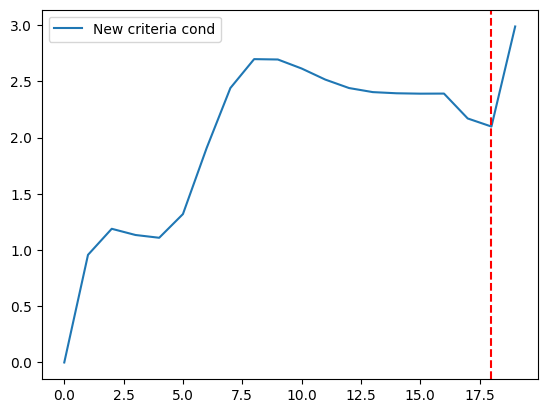

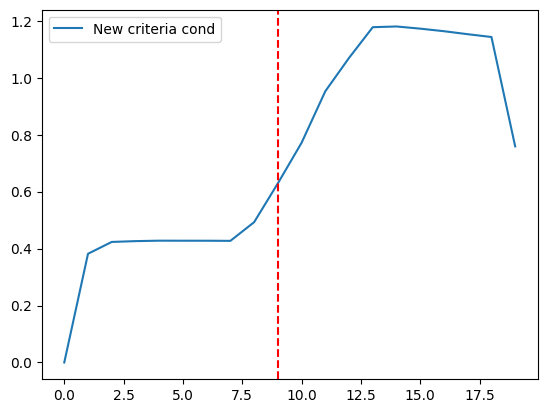

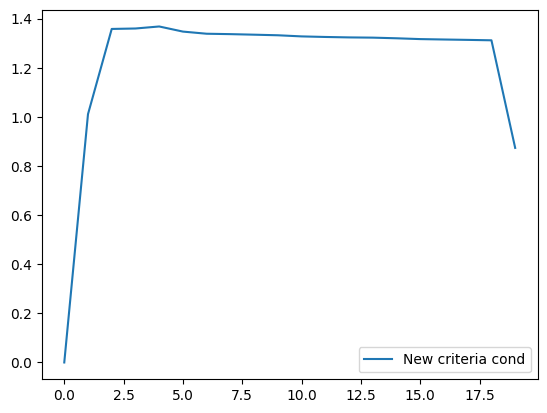

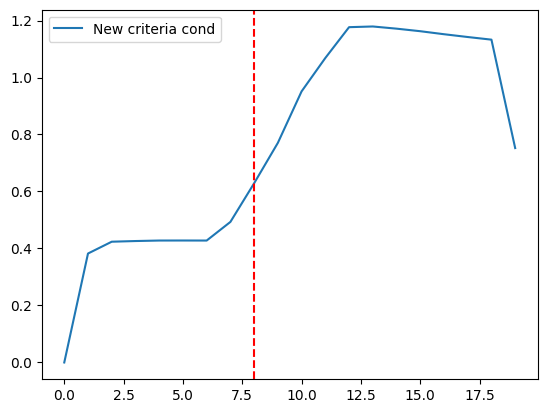

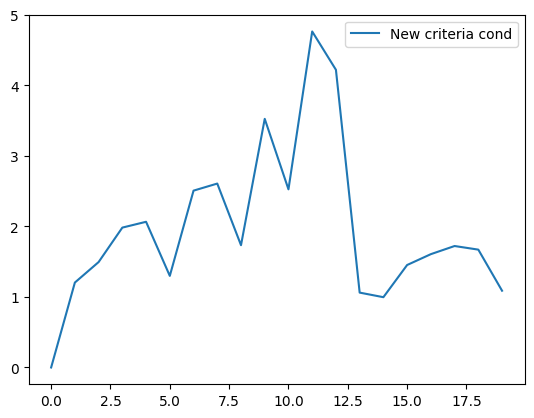

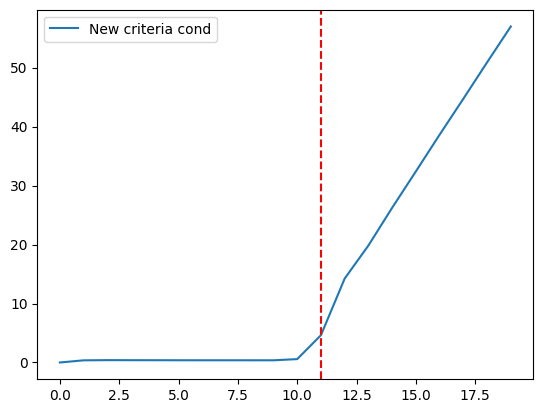

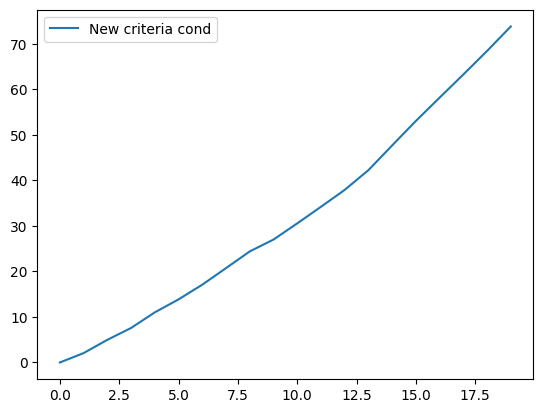

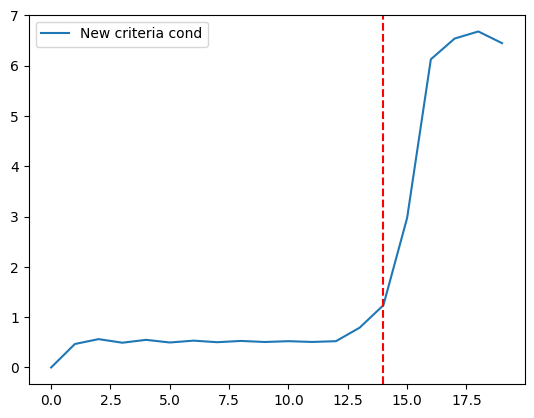

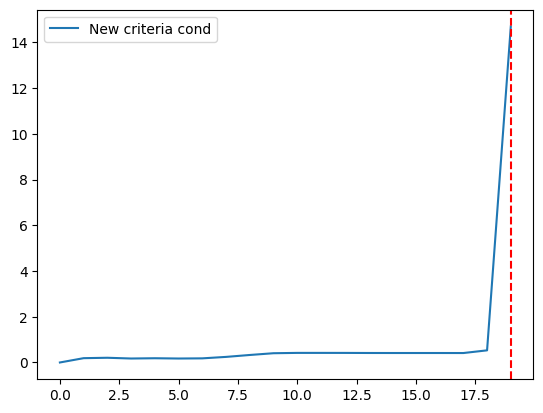

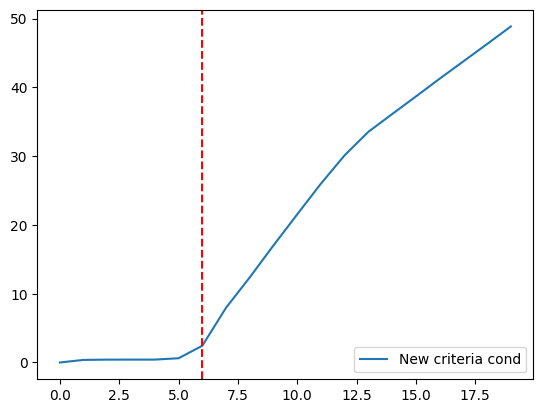

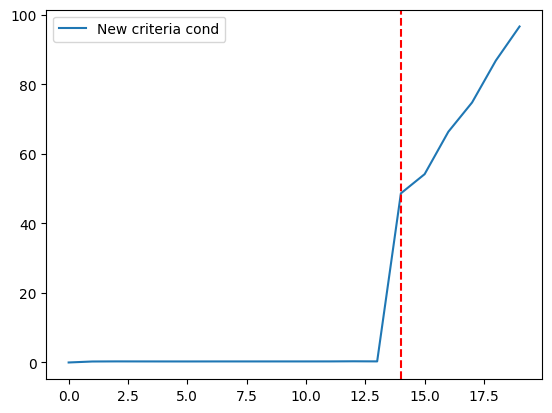

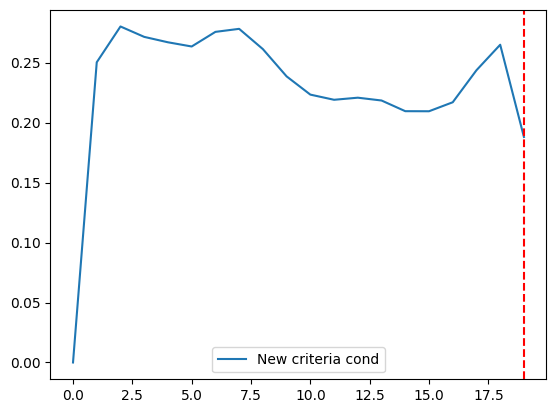

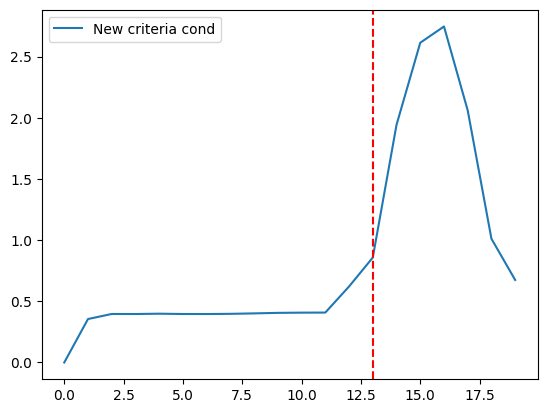

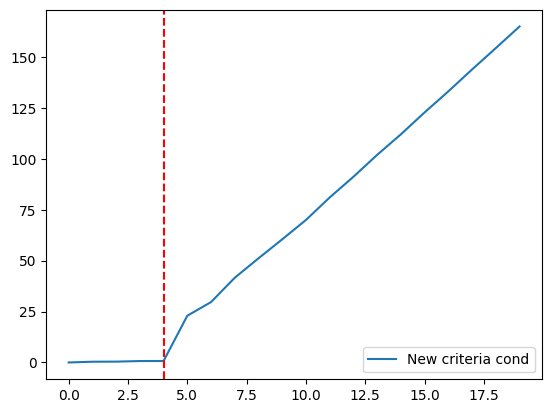

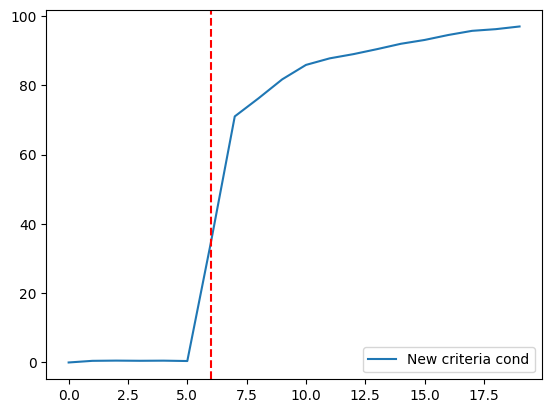

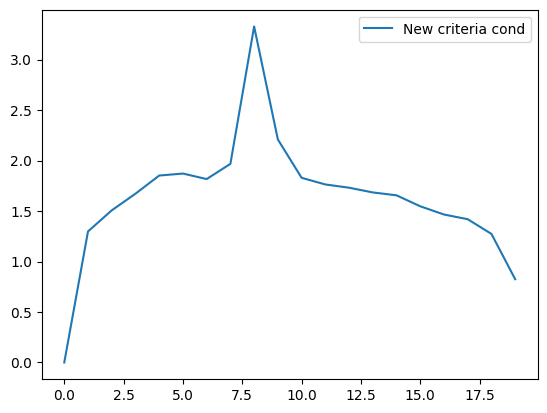

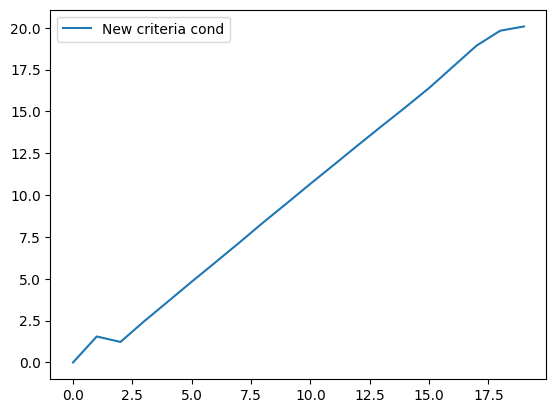

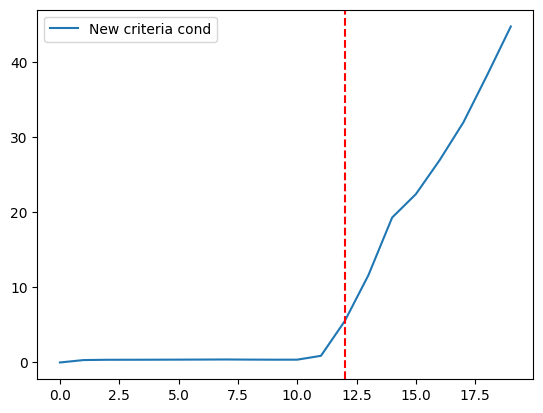

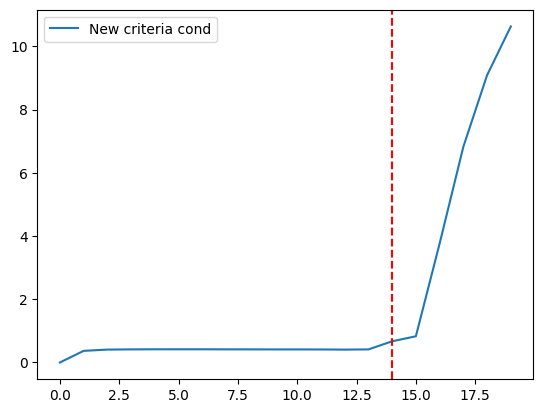

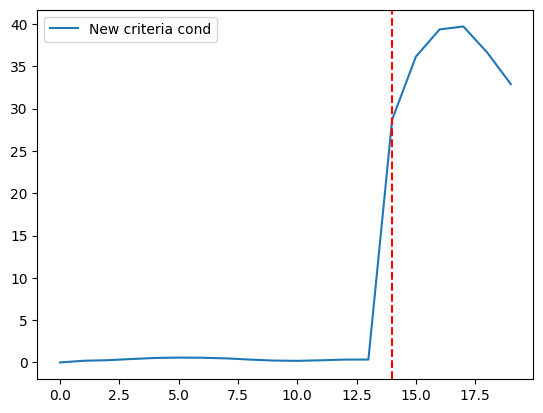

In [29]:
for IDX in range(20):
    change_idx = labels_batch[IDX].detach().cpu().numpy().argmax()

    plt.figure()
    # plt.plot(cusum_old[IDX], label="Old CUSUM")
    # plt.plot(cusum_correct_noncond[IDX], label="Correct CUSUM non-cond")
    # plt.plot(cusum_correct_cond[IDX], label="New CUSUM cond")
    # plt.plot(new_crit_noncond[IDX], label="New criteria non-cond")
    plt.plot(new_crit_cond[IDX], label="New criteria cond")

    if change_idx > 0:
        plt.axvline(x=change_idx, c="red", linestyle="--")
    plt.legend()
    plt.show()

In [34]:
cusum_threshold_list = np.linspace(0, 10, 100)

evaluate_cusum_ensemble_model(
    cusum_threshold_list=cusum_threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    args_config=args_config,
    n_models=10,
    save_path=path_to_models_folder,
    cusum_mode="old",
    conditional=True,
    global_sigma=global_sigma,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
    device="cpu",
    verbose=True,
);

100%|██████████| 100/100 [03:29<00:00,  2.10s/it]

Results for best threshold = 0.7070707070707071
AUDC: 0.0, Time to FA: 9.736, DD: 0.6313, F1: 0.9172, Cover: 0.9289, Max Cover: 0.9289
Max F1 with margin 1: 0.8872
Max F1 with margin 2: 0.8911
Max F1 with margin 4: 0.9102


In [41]:
cusum_threshold_list = np.linspace(0, 10, 100)

evaluate_cusum_ensemble_model(
    cusum_threshold_list=cusum_threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    args_config=args_config,
    n_models=10,
    save_path=path_to_models_folder,
    cusum_mode="correct",
    conditional=False,
    global_sigma=global_sigma,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
    device="cpu",
    verbose=True,
    # write_metrics_filename=path_to_metrics,
);

100%|██████████| 100/100 [03:21<00:00,  2.02s/it]

Results for best threshold = 3.0303030303030303
AUDC: 0.0, Time to FA: 10.6133, DD: 1.5946, F1: 0.8665, Cover: 0.88, Max Cover: 0.88
Max F1 with margin 1: 0.761
Max F1 with margin 2: 0.835
Max F1 with margin 4: 0.8665


In [42]:
cusum_threshold_list = np.linspace(0, 10, 100)

evaluate_cusum_ensemble_model(
    cusum_threshold_list=cusum_threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    args_config=args_config,
    n_models=10,
    save_path=path_to_models_folder,
    cusum_mode="correct",
    conditional=True,
    global_sigma=global_sigma,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
    device="cpu",
    verbose=True,
);

100%|██████████| 100/100 [03:21<00:00,  2.01s/it]

Results for best threshold = 1.4141414141414141
AUDC: 0.0, Time to FA: 10.7592, DD: 1.6313, F1: 0.8685, Cover: 0.8792, Max Cover: 0.8792
Max F1 with margin 1: 0.7508
Max F1 with margin 2: 0.838
Max F1 with margin 4: 0.8685


In [43]:
cusum_threshold_list = np.linspace(0, 10, 100)

evaluate_cusum_ensemble_model(
    cusum_threshold_list=cusum_threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    args_config=args_config,
    n_models=10,
    save_path=path_to_models_folder,
    cusum_mode="new_criteria",
    conditional=False,
    global_sigma=global_sigma,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
    device="cpu",
    verbose=True,
    # write_metrics_filename=path_to_metrics,
);

100%|██████████| 100/100 [03:20<00:00,  2.00s/it]

Results for best threshold = 1.1111111111111112
AUDC: 0.0, Time to FA: 8.4488, DD: 0.6829, F1: 0.8897, Cover: 0.918, Max Cover: 0.918
Max F1 with margin 1: 0.8263
Max F1 with margin 2: 0.8589
Max F1 with margin 4: 0.8855


100%|██████████| 100/100 [03:20<00:00,  2.00s/it]Results for best threshold = 1.1111111111111112
AUDC: 0.0, Time to FA: 8.4488, DD: 0.6829, F1: 0.8897, Cover: 0.918, Max Cover: 0.918
Max F1 with margin 1: 0.8263
Max F1 with margin 2: 0.8589
Max F1 with margin 4: 0.8855

In [44]:
cusum_threshold_list = np.linspace(0, 10, 100)

evaluate_cusum_ensemble_model(
    cusum_threshold_list=cusum_threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    args_config=args_config,
    n_models=10,
    save_path=path_to_models_folder,
    cusum_mode="new_criteria",
    conditional=True,
    global_sigma=global_sigma,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
    device="cpu",
    verbose=True,
);

100%|██████████| 100/100 [03:21<00:00,  2.01s/it]

Results for best threshold = 1.1111111111111112
AUDC: 0.0, Time to FA: 8.4503, DD: 0.6844, F1: 0.8897, Cover: 0.9179, Max Cover: 0.9179
Max F1 with margin 1: 0.8257
Max F1 with margin 2: 0.8589
Max F1 with margin 4: 0.8855


## Distances

In [14]:
# collecting outputs
test_out_bank, _, test_labels_bank = collect_model_predictions_on_set(
    ens_har_sgld, test_dataloader, model_type="ensemble_all_models", device="cpu"
)

all_models_out_dataset = AllModelsOutputDataset(test_out_bank, test_labels_bank)
all_models_out_dataloader = DataLoader(
    all_models_out_dataset, batch_size=128, shuffle=False
)

preds, labels = all_models_out_dataset[0]
preds.shape, labels.shape

Collectting model's outputs


(torch.Size([10, 20]), torch.Size([20]))

In [16]:
res_dict = {}

window_size_list = [1, 2, 3]
anchor_window_type_list = ["start", "prev"]

threshold_list = np.linspace(0, 1, 50)

for window_size, anchor_window_type in itertools.product(
    window_size_list, anchor_window_type_list
):
    print(f"window_size = {window_size}, anchor_window_type = {anchor_window_type}")
    res, best_th = evaluate_distance_ensemble_model(
        threshold_list=threshold_list,
        output_dataloader=all_models_out_dataloader,
        margin_list=[1, 2, 4],
        args_config=args_config,
        n_models=10,
        window_size=window_size,
        # kernel="rbf",
        anchor_window_type=anchor_window_type,
        distance="wasserstein",
        save_path=path_to_models_folder,
        device="cpu",
        verbose=True,
    )

    res_dict[(window_size, anchor_window_type)] = res[best_th]

  0%|          | 0/50 [00:00<?, ?it/s]

window_size = 1, anchor_window_type = start


  0%|          | 0/50 [00:00<?, ?it/s]

Results for best threshold = 0.12244897959183673
AUDC: 0.0, Time to FA: 8.2999, DD: 1.1429, F1: 0.9064, Cover: 0.8688, Max Cover: 0.8688
Max F1 with margin 1: 0.7822
Max F1 with margin 2: 0.8767
Max F1 with margin 4: 0.9009
window_size = 1, anchor_window_type = prev


  0%|          | 0/50 [00:00<?, ?it/s]

Results for best threshold = 0.08163265306122448
AUDC: 0.0, Time to FA: 7.9903, DD: 0.9723, F1: 0.9064, Cover: 0.8817, Max Cover: 0.8817
Max F1 with margin 1: 0.8149
Max F1 with margin 2: 0.8929
Max F1 with margin 4: 0.906
window_size = 2, anchor_window_type = start


  0%|          | 0/50 [00:00<?, ?it/s]

Results for best threshold = 0.12244897959183673
AUDC: 0.0, Time to FA: 9.0755, DD: 1.5183, F1: 0.913, Cover: 0.8467, Max Cover: 0.8467
Max F1 with margin 1: 0.6121
Max F1 with margin 2: 0.8522
Max F1 with margin 4: 0.9018
window_size = 2, anchor_window_type = prev


  0%|          | 0/50 [00:00<?, ?it/s]

Results for best threshold = 0.1020408163265306
AUDC: 0.0, Time to FA: 9.1496, DD: 1.4839, F1: 0.9097, Cover: 0.8557, Max Cover: 0.8557
Max F1 with margin 1: 0.6548
Max F1 with margin 2: 0.8627
Max F1 with margin 4: 0.9065
window_size = 3, anchor_window_type = start


  0%|          | 0/50 [00:00<?, ?it/s]

Results for best threshold = 0.12244897959183673
AUDC: 0.0, Time to FA: 9.6043, DD: 1.8018, F1: 0.9225, Cover: 0.8352, Max Cover: 0.8352
Max F1 with margin 1: 0.5057
Max F1 with margin 2: 0.7998
Max F1 with margin 4: 0.9025
window_size = 3, anchor_window_type = prev


100%|██████████| 50/50 [03:05<00:00,  3.70s/it]

Results for best threshold = 0.12244897959183673
AUDC: 0.0, Time to FA: 9.9372, DD: 1.9237, F1: 0.9163, Cover: 0.8397, Max Cover: 0.8397
Max F1 with margin 1: 0.5087
Max F1 with margin 2: 0.8002
Max F1 with margin 4: 0.9029


# BCE-SGLD Explosion

In [47]:
model_type = "seq2seq"

experiments_name = "explosion"

path_to_config = "configs/" + "video" + "_" + model_type + ".yaml"

with open(path_to_config, "r") as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type

args_config["loss_type"] = "bce"
args_config["num_workers"] = 4
args_config["learning"]["gpus"] = 1

args_config["learning"]["epochs"] = 100

In [48]:
train_dataset, test_dataset = CPDDatasets(experiments_name).get_dataset_()
test_dataloader = DataLoader(
    test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False
)
seq_batch, labels_batch = next(iter(test_dataloader))

In [6]:
args_config["learning"]["lr"] = 1e-3
args_config["learning"]["temperature"] = 0.001

# for ABAnnealingLR
args_config["learning"]["final_lr"] = 1e-4
args_config["learning"]["gamma"] = 0.5
args_config["learning"]["T_max"] = 50000

In [50]:
# path_to_models_folder = "saved_models/bce/explosion/sgld_adam"

path_to_models_folder = "saved_models/bce/explosion/layer_norm/train_anomaly_num_155"

ens_bce = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)
ens_bce.load_models_list(path_to_models_folder)

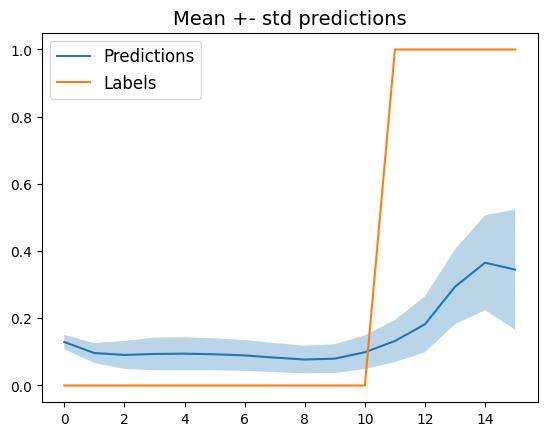

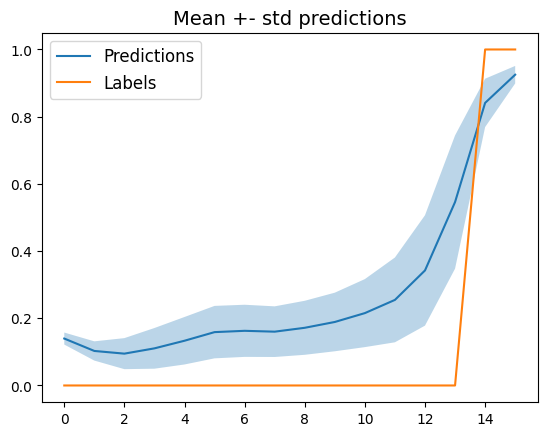

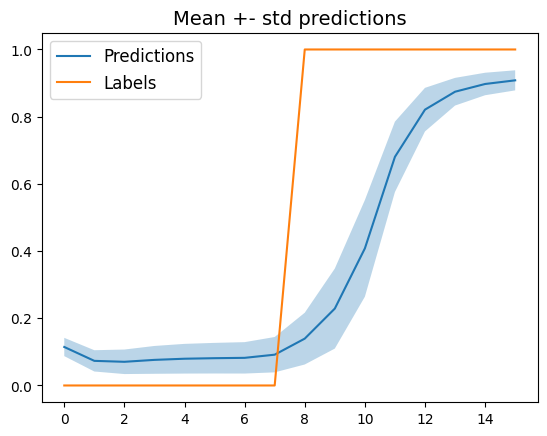

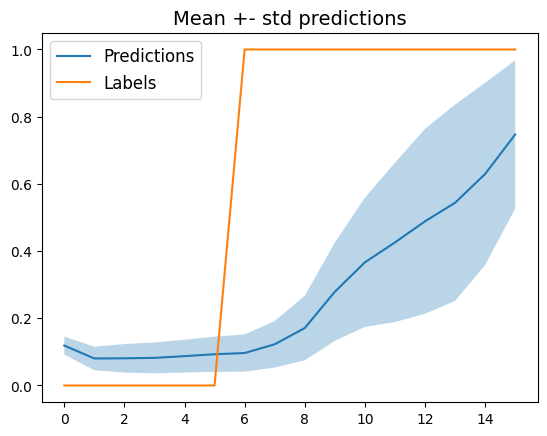

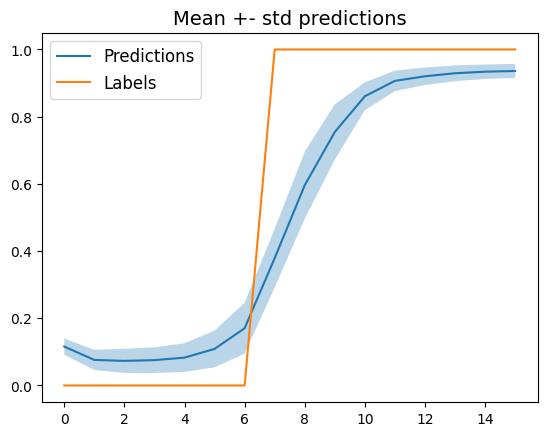

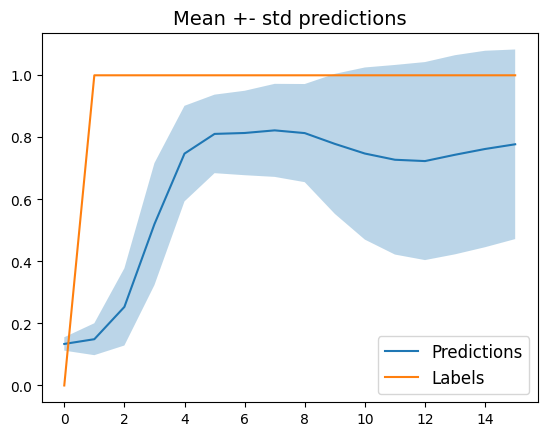

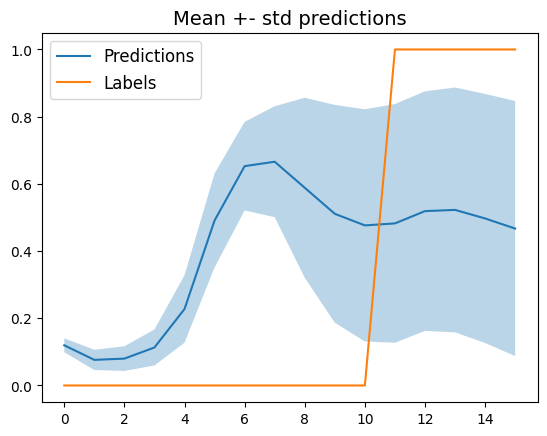

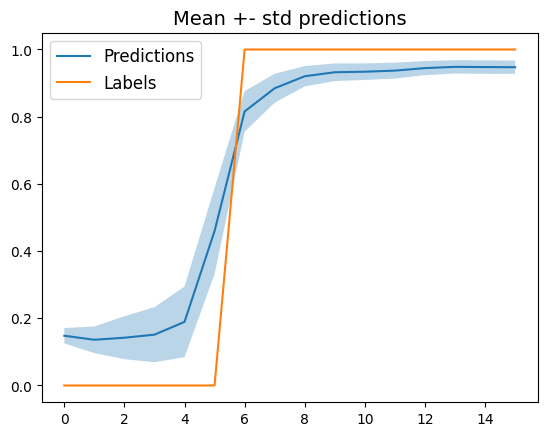

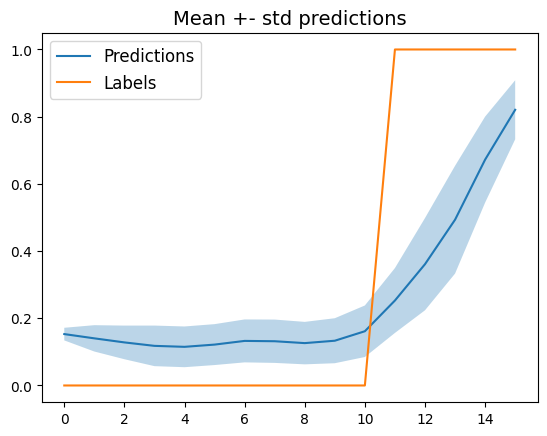

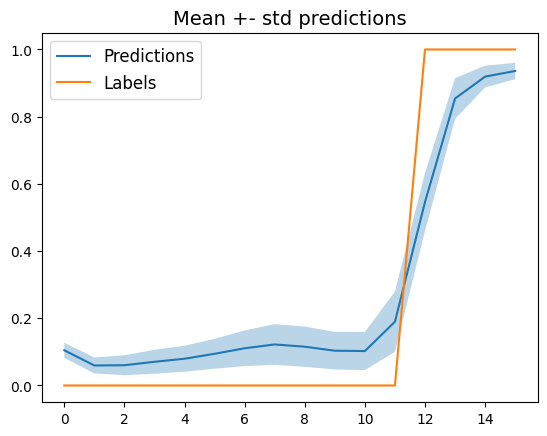

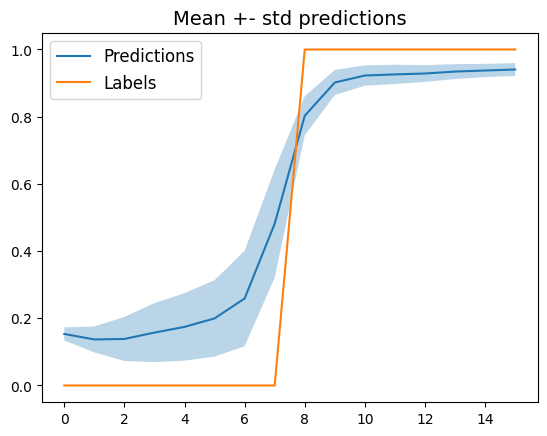

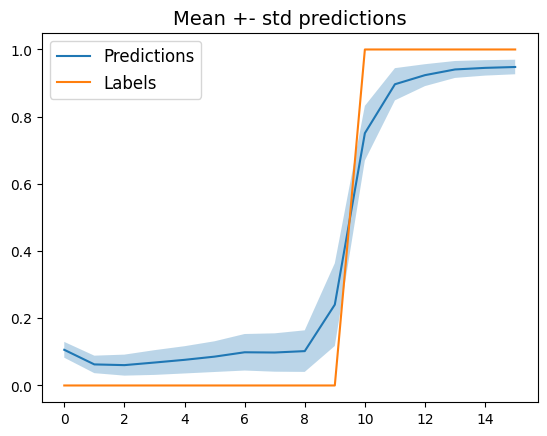

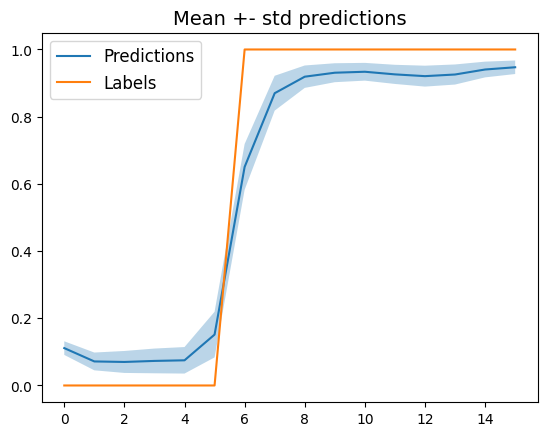

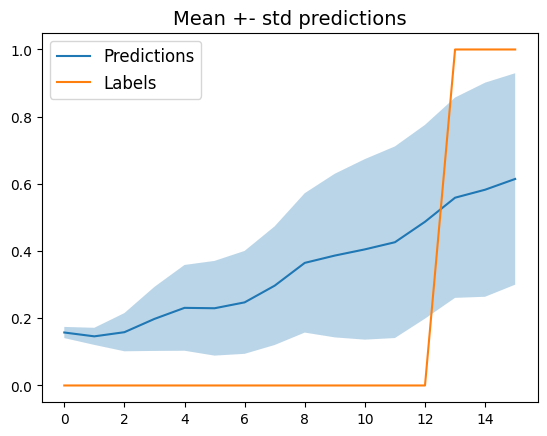

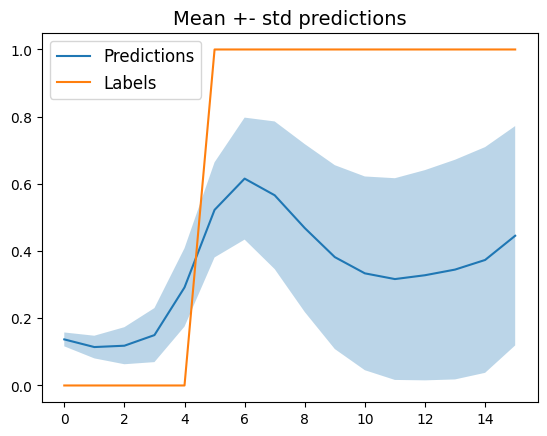

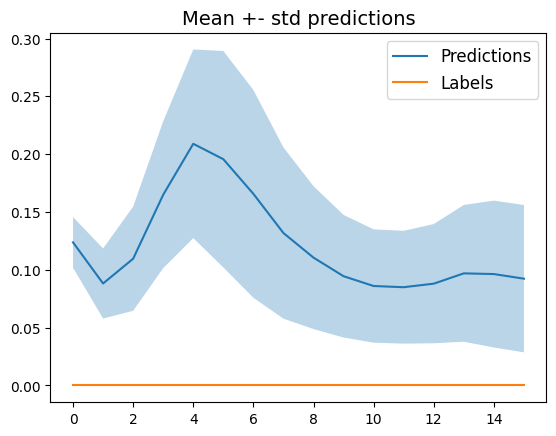

In [51]:
visualize_predictions(
    ens_bce, "ensemble", seq_batch, labels_batch, n_pics=16, device="cuda"
)

In [52]:
threshold_number = 100
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

In [53]:
# compute metrics
metrics, (max_th_f1_margins_dict, max_f1_margins_dic), _, _ = evaluation_pipeline(
    ens_bce,
    test_dataloader,
    threshold_list,
    device="cuda",  # choose 'cpu' or 'cuda' if available
    model_type="ensemble",
    verbose=True,
    margin_list=[1, 2, 4],
)

  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


100%|██████████| 20/20 [02:42<00:00,  8.15s/it]


TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0

In [12]:
# collecting outputs
test_out_bank, test_uncertainties_bank, test_labels_bank = (
    collect_model_predictions_on_set(
        ens_bce, test_dataloader, model_type="ensemble", device="cuda"
    )
)

out_dataset = OutputDataset(test_out_bank, test_uncertainties_bank, test_labels_bank)
out_dataloader = DataLoader(out_dataset, batch_size=128, shuffle=False)

(preds, stds), labels = out_dataset[0]
preds.shape, stds.shape, labels.shape

  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


100%|██████████| 20/20 [02:39<00:00,  7.97s/it]


(torch.Size([16]), torch.Size([16]), torch.Size([16]))

In [13]:
metrics, (max_th_f1_margins_dict, max_f1_margins_dic), _, _ = evaluation_pipeline(
    ens_bce,
    out_dataloader,
    threshold_list,
    device="cpu",
    model_type="fake_ensemble",
    verbose=True,
    margin_list=[1, 2, 4],
)

100%|██████████| 3/3 [00:00<00:00, 203.44it/s]

Collectting model's outputs


TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0

In [14]:
compute_stds(
    ens_bce, test_dataloader, windows_list=[1, 2, 3, 4], verbose=True, device="cuda"
);

  0%|          | 0/20 [00:00<?, ?it/s]

Computing model's outputs...


100%|██████████| 20/20 [02:40<00:00,  8.05s/it]


Window: 1
CP stds list:
Mean = 0.11504567054410776, number is 15
Normal stds list:
Mean = 0.04304712459112808, number is 314
p_val analytical = 0.0051428707954451, p_val permutational = 0.041
Stds are not statistically equal
--------------------------------------------------
Window: 2
CP stds list:
Mean = 0.10623201181491217, number is 15
Normal stds list:
Mean = 0.04288165235690251, number is 314
p_val analytical = 0.00948072731245686, p_val permutational = 0.0443
Stds are not statistically equal
--------------------------------------------------
Window: 3
CP stds list:
Mean = 0.10519349525372187, number is 15
Normal stds list:
Mean = 0.04275853766994492, number is 314
p_val analytical = 0.00696387325653614, p_val permutational = 0.0342
Stds are not statistically equal
--------------------------------------------------
Window: 4
CP stds list:
Mean = 0.10291916678349176, number is 15
Normal stds list:
Mean = 0.04261286695529321, number is 314
p_val analytical = 0.005485647195359758, p_

In [18]:
device = "cuda:1"

seq_batch = seq_batch.to(device)

In [20]:
norm_sigma = 0.043047
cp_sigma = 0.115045

global_sigma = norm_sigma
lambda_null = 1.0 / cp_sigma**2
lambda_inf = 1.0 / norm_sigma**2
half_wnd = 1

ens_explosion_sgld_old = CusumEnsembleCPDModel(
    args_config,
    n_models=10,
    global_sigma=global_sigma,
    seed=0,
    cusum_threshold=10,
    cusum_mode="old",
    conditional=True,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
)
ens_explosion_sgld_old.load_models_list(path_to_models_folder)
ens_explosion_sgld_old.to(device)

_ = ens_explosion_sgld_old.predict(seq_batch)
cusum_old = ens_explosion_sgld_old.normal_to_change_stats.detach().cpu()

del ens_explosion_sgld_old
print("111")

# ----------------------------------------------------------- #

ens_explosion_sgld_correct_noncond = CusumEnsembleCPDModel(
    args_config,
    n_models=10,
    global_sigma=global_sigma,
    seed=0,
    cusum_threshold=10,
    cusum_mode="correct",
    conditional=False,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
)
ens_explosion_sgld_correct_noncond.load_models_list(path_to_models_folder)
ens_explosion_sgld_correct_noncond.to(device)

_ = ens_explosion_sgld_correct_noncond.predict(seq_batch)
cusum_correct_noncond = (
    ens_explosion_sgld_correct_noncond.normal_to_change_stats.detach().cpu()
)

del ens_explosion_sgld_correct_noncond
print("222")

# ----------------------------------------------------------- #

ens_explosion_sgld_correct_cond = CusumEnsembleCPDModel(
    args_config,
    n_models=10,
    global_sigma=global_sigma,
    seed=0,
    cusum_threshold=10,
    cusum_mode="correct",
    conditional=True,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
)
ens_explosion_sgld_correct_cond.load_models_list(path_to_models_folder)
ens_explosion_sgld_correct_cond.to(device)

_ = ens_explosion_sgld_correct_cond.predict(seq_batch)
cusum_correct_cond = (
    ens_explosion_sgld_correct_cond.normal_to_change_stats.detach().cpu()
)

del ens_explosion_sgld_correct_cond
print("333")

# ----------------------------------------------------------- #

ens_explosion_sgld_new_crit_noncond = CusumEnsembleCPDModel(
    args_config,
    n_models=10,
    global_sigma=global_sigma,
    seed=0,
    cusum_threshold=10,
    cusum_mode="new_criteria",
    conditional=False,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
)
ens_explosion_sgld_new_crit_noncond.load_models_list(path_to_models_folder)
ens_explosion_sgld_new_crit_noncond.to(device)

_ = ens_explosion_sgld_new_crit_noncond.predict(seq_batch)
new_crit_noncond = (
    ens_explosion_sgld_new_crit_noncond.normal_to_change_stats.detach().cpu()
)

del ens_explosion_sgld_new_crit_noncond
print("444")

# ----------------------------------------------------------- #

ens_explosion_sgld_new_crit_cond = CusumEnsembleCPDModel(
    args_config,
    n_models=10,
    global_sigma=global_sigma,
    seed=0,
    cusum_threshold=10,
    cusum_mode="new_criteria",
    conditional=True,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
)
ens_explosion_sgld_new_crit_cond.load_models_list(path_to_models_folder)
ens_explosion_sgld_new_crit_cond.to(device)

_ = ens_explosion_sgld_new_crit_cond.predict(seq_batch)
new_crit_cond = ens_explosion_sgld_new_crit_cond.normal_to_change_stats.detach().cpu()

del ens_explosion_sgld_new_crit_cond

111
222
333
444


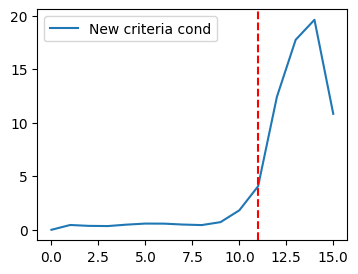

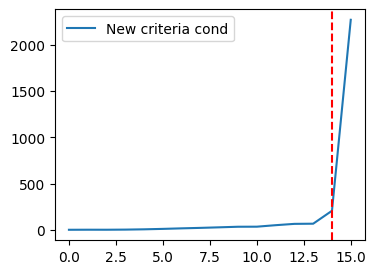

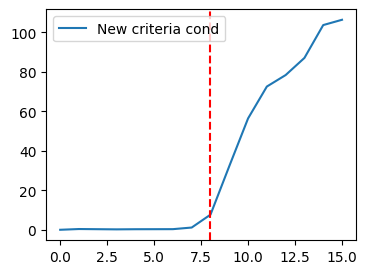

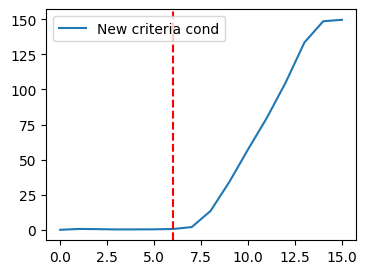

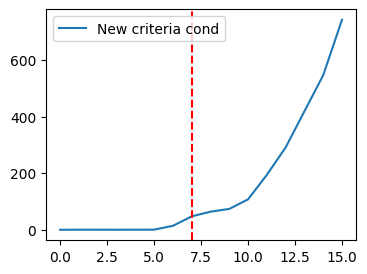

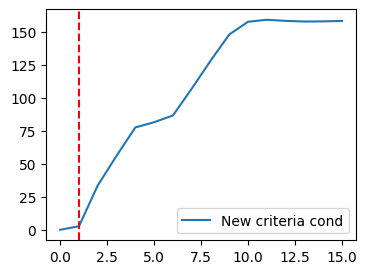

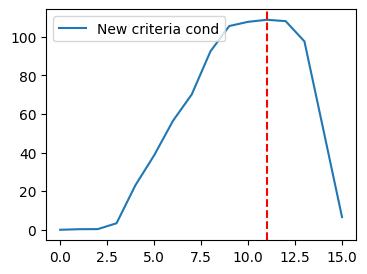

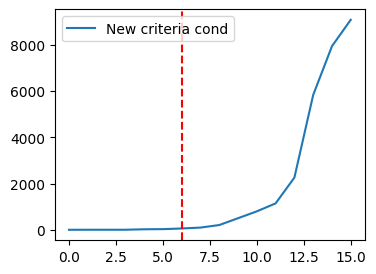

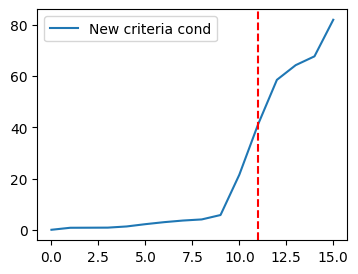

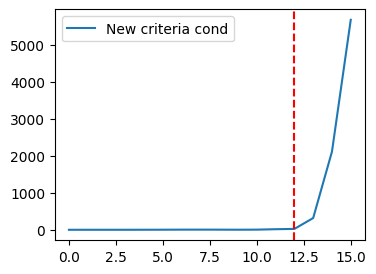

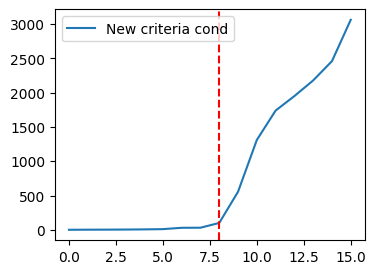

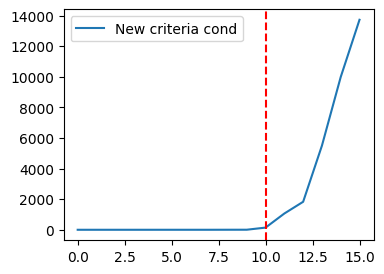

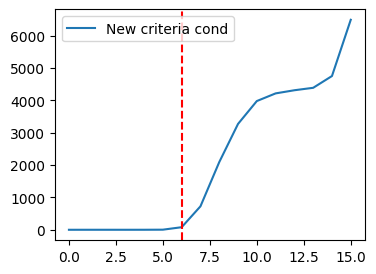

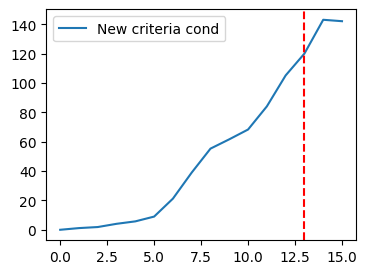

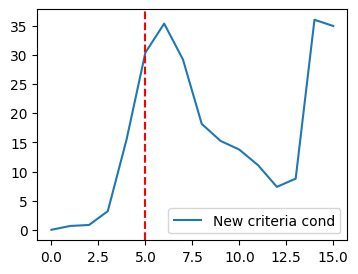

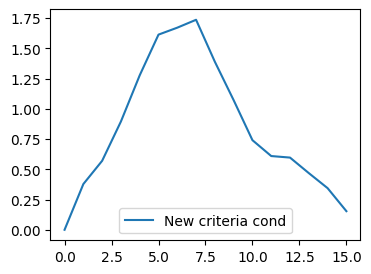

In [37]:
for IDX in range(16):
    change_idx = labels_batch[IDX].detach().cpu().numpy().argmax()

    plt.figure(figsize=(4, 3))
    # plt.plot(cusum_old[IDX], label="Old CUSUM")
    # plt.plot(cusum_correct_noncond[IDX], label="Correct CUSUM non-cond")
    # plt.plot(cusum_correct_cond[IDX], label="New CUSUM cond")
    # plt.plot(new_crit_noncond[IDX], label="New criteria non-cond")
    plt.plot(new_crit_cond[IDX], label="New criteria cond")

    if change_idx > 0:
        plt.axvline(x=change_idx, c="red", linestyle="--")
    plt.legend()
    plt.show()

In [38]:
path_to_metrics = "results/bce/explosion/sgld_adam/BCE_sgld_adam_ensemble.txt"

In [40]:
cusum_threshold_list = np.linspace(0, 10, 200)

evaluate_cusum_ensemble_model(
    cusum_threshold_list=cusum_threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    args_config=args_config,
    n_models=10,
    save_path=path_to_models_folder,
    cusum_mode="old",
    conditional=True,
    global_sigma=global_sigma,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
    device="cpu",
    verbose=True,
    # write_metrics_filename=path_to_metrics
);

100%|██████████| 200/200 [20:49<00:00,  6.25s/it]

Results for best threshold = 5.376884422110553
AUDC: 0.0, Time to FA: 15.7905, DD: 0.2095, F1: 0.6667, Cover: 0.9877, Max Cover: 0.9877
Max F1 with margin 1: 0.5455
Max F1 with margin 2: 0.5455
Max F1 with margin 4: 0.6667


In [41]:
cusum_threshold_list = np.linspace(0, 2000, 200)

evaluate_cusum_ensemble_model(
    cusum_threshold_list=cusum_threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    args_config=args_config,
    n_models=10,
    save_path=path_to_models_folder,
    cusum_mode="correct",
    conditional=False,
    global_sigma=global_sigma,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
    device="cpu",
    verbose=True,
    # write_metrics_filename=path_to_metrics
);

100%|██████████| 200/200 [20:45<00:00,  6.23s/it]

Results for best threshold = 271.356783919598
AUDC: 0.0, Time to FA: 15.6635, DD: 0.1619, F1: 0.6897, Cover: 0.9847, Max Cover: 0.9847
Max F1 with margin 1: 0.48
Max F1 with margin 2: 0.48
Max F1 with margin 4: 0.6429


In [42]:
cusum_threshold_list = np.linspace(0, 2000, 200)

evaluate_cusum_ensemble_model(
    cusum_threshold_list=cusum_threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    args_config=args_config,
    n_models=10,
    save_path=path_to_models_folder,
    cusum_mode="correct",
    conditional=True,
    global_sigma=global_sigma,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
    device="cpu",
    verbose=True,
    # write_metrics_filename=path_to_metrics
);

100%|██████████| 200/200 [20:48<00:00,  6.24s/it]

Results for best threshold = 10.050251256281408
AUDC: 0.0, Time to FA: 15.6762, DD: 0.146, F1: 0.7143, Cover: 0.9872, Max Cover: 0.9872
Max F1 with margin 1: 0.5
Max F1 with margin 2: 0.56
Max F1 with margin 4: 0.6667


In [43]:
cusum_threshold_list = np.linspace(0, 2000, 200)

evaluate_cusum_ensemble_model(
    cusum_threshold_list=cusum_threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    args_config=args_config,
    n_models=10,
    save_path=path_to_models_folder,
    cusum_mode="new_criteria",
    conditional=False,
    global_sigma=global_sigma,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
    device="cpu",
    verbose=True,
    # write_metrics_filename=path_to_metrics
);

100%|██████████| 200/200 [20:48<00:00,  6.24s/it]

Results for best threshold = 311.55778894472365
AUDC: 0.0, Time to FA: 15.6571, DD: 0.1619, F1: 0.6897, Cover: 0.9843, Max Cover: 0.9843
Max F1 with margin 1: 0.48
Max F1 with margin 2: 0.48
Max F1 with margin 4: 0.6429


In [44]:
cusum_threshold_list = np.linspace(0, 2000, 200)

evaluate_cusum_ensemble_model(
    cusum_threshold_list=cusum_threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    args_config=args_config,
    n_models=10,
    save_path=path_to_models_folder,
    cusum_mode="new_criteria",
    conditional=True,
    global_sigma=global_sigma,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
    device="cpu",
    verbose=True,
    # write_metrics_filename=path_to_metrics
);

100%|██████████| 200/200 [20:50<00:00,  6.25s/it]

Results for best threshold = 130.6532663316583
AUDC: 0.0, Time to FA: 15.6698, DD: 0.1873, F1: 0.6667, Cover: 0.9823, Max Cover: 0.9823
Max F1 with margin 1: 0.4615
Max F1 with margin 2: 0.5185
Max F1 with margin 4: 0.5714


## Distances

In [54]:
# collecting outputs
test_out_bank, _, test_labels_bank = collect_model_predictions_on_set(
    ens_bce, test_dataloader, model_type="ensemble_all_models", device="cuda:1"
)

all_models_out_dataset = AllModelsOutputDataset(test_out_bank, test_labels_bank)
all_models_out_dataloader = DataLoader(
    all_models_out_dataset, batch_size=128, shuffle=False
)

preds, labels = all_models_out_dataset[0]
preds.shape, labels.shape

  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


100%|██████████| 20/20 [02:42<00:00,  8.14s/it]


(torch.Size([10, 16]), torch.Size([16]))

In [55]:
res_dict = {}

window_size_list = [1, 2, 3]
anchor_window_type_list = ["prev"]

threshold_list = np.linspace(0, 1, 50)

for window_size, anchor_window_type in itertools.product(
    window_size_list, anchor_window_type_list
):
    print(f"window_size = {window_size}, anchor_window_type = {anchor_window_type}")

    res, best_th = evaluate_distance_ensemble_model(
        threshold_list=threshold_list,
        output_dataloader=all_models_out_dataloader,
        margin_list=[1, 2, 4],
        args_config=args_config,
        n_models=10,
        window_size=window_size,
        # kernel="rbf",
        anchor_window_type=anchor_window_type,
        distance="wasserstein",
        save_path=path_to_models_folder,
        device="cpu",
        verbose=True,
    )

    res_dict[(window_size, anchor_window_type)] = res[best_th]

  0%|          | 0/50 [00:00<?, ?it/s]

window_size = 1, anchor_window_type = prev


  0%|          | 0/50 [00:00<?, ?it/s]

Results for best threshold = 0.2040816326530612
AUDC: 0.0, Time to FA: 15.6571, DD: 0.1143, F1: 0.7143, Cover: 0.988, Max Cover: 0.988
Max F1 with margin 1: 0.6154
Max F1 with margin 2: 0.6154
Max F1 with margin 4: 0.7143
window_size = 2, anchor_window_type = prev


  0%|          | 0/50 [00:00<?, ?it/s]

Results for best threshold = 0.26530612244897955
AUDC: 0.0, Time to FA: 15.6254, DD: 0.127, F1: 0.7586, Cover: 0.9851, Max Cover: 0.9851
Max F1 with margin 1: 0.5
Max F1 with margin 2: 0.6154
Max F1 with margin 4: 0.8
window_size = 3, anchor_window_type = prev


100%|██████████| 50/50 [05:38<00:00,  6.78s/it]

Results for best threshold = 0.2857142857142857
AUDC: 0.0, Time to FA: 15.6317, DD: 0.1365, F1: 0.7857, Cover: 0.9841, Max Cover: 0.9841
Max F1 with margin 1: 0.3
Max F1 with margin 2: 0.64
Max F1 with margin 4: 0.8276


In [46]:
res_dict = {}

window_size_list = [1, 2, 3]
anchor_window_type_list = ["start", "prev"]

threshold_list = np.linspace(0, 1, 50)

for window_size, anchor_window_type in itertools.product(
    window_size_list, anchor_window_type_list
):
    print(f"window_size = {window_size}, anchor_window_type = {anchor_window_type}")

    res, best_th = evaluate_distance_ensemble_model(
        threshold_list=threshold_list,
        output_dataloader=all_models_out_dataloader,
        margin_list=[1, 2, 4],
        args_config=args_config,
        n_models=10,
        window_size=window_size,
        # kernel="rbf",
        anchor_window_type=anchor_window_type,
        distance="wasserstein",
        save_path=path_to_models_folder,
        device="cpu",
        verbose=True,
    )

    res_dict[(window_size, anchor_window_type)] = res[best_th]

  0%|          | 0/50 [00:00<?, ?it/s]

window_size = 1, anchor_window_type = start


  0%|          | 0/50 [00:00<?, ?it/s]

Results for best threshold = 0.6122448979591836
AUDC: 0.0, Time to FA: 15.673, DD: 0.1587, F1: 0.6897, Cover: 0.9849, Max Cover: 0.9849
Max F1 with margin 1: 0.48
Max F1 with margin 2: 0.48
Max F1 with margin 4: 0.7333
window_size = 1, anchor_window_type = prev


  0%|          | 0/50 [00:00<?, ?it/s]

Results for best threshold = 0.2857142857142857
AUDC: 0.0, Time to FA: 15.6476, DD: 0.1333, F1: 0.7143, Cover: 0.9871, Max Cover: 0.9871
Max F1 with margin 1: 0.56
Max F1 with margin 2: 0.6154
Max F1 with margin 4: 0.7143
window_size = 2, anchor_window_type = start


  0%|          | 0/50 [00:00<?, ?it/s]

Results for best threshold = 0.5714285714285714
AUDC: 0.0, Time to FA: 15.6667, DD: 0.1746, F1: 0.7143, Cover: 0.9826, Max Cover: 0.9826
Max F1 with margin 1: 0.2857
Max F1 with margin 2: 0.5
Max F1 with margin 4: 0.6667
window_size = 2, anchor_window_type = prev


  0%|          | 0/50 [00:00<?, ?it/s]

Results for best threshold = 0.3877551020408163
AUDC: 0.0, Time to FA: 15.6857, DD: 0.1556, F1: 0.7407, Cover: 0.986, Max Cover: 0.986
Max F1 with margin 1: 0.4545
Max F1 with margin 2: 0.5833
Max F1 with margin 4: 0.7857
window_size = 3, anchor_window_type = start


  0%|          | 0/50 [00:00<?, ?it/s]

Results for best threshold = 0.5306122448979591
AUDC: 0.0, Time to FA: 15.7048, DD: 0.181, F1: 0.7407, Cover: 0.9832, Max Cover: 0.9832
Max F1 with margin 1: 0.1111
Max F1 with margin 2: 0.5217
Max F1 with margin 4: 0.6923
window_size = 3, anchor_window_type = prev


100%|██████████| 50/50 [05:30<00:00,  6.61s/it]

Results for best threshold = 0.3469387755102041
AUDC: 0.0, Time to FA: 15.6698, DD: 0.1651, F1: 0.7407, Cover: 0.9836, Max Cover: 0.9836
Max F1 with margin 1: 0.3
Max F1 with margin 2: 0.5217
Max F1 with margin 4: 0.7857
